# Nationwide Application Assessment for Computational Telematics
## Part 2
# Jason Barkeloo

Now let's import necessary libraries. <br>
numpy for various linear algebra libraries<br>
pandas for convenient file reading as well as dataframe structures that are convenient to work with<br>
matplotlib for various basic plots<br>
geopy for geodesic distances used for calculations in part 1
sklearn, keras (using locally installed tensorflow) for neural network applications

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import sys
import sklearn
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model,Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import xgboost as xgb

Using TensorFlow backend.
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Part 2 Modeling

In [136]:
sim_sum_tot = pd.read_csv(r"C:\Users\JTBar\Documents\Telematics Exercise Files\simulated_summary_total.csv")

In [137]:
sim_sum_tot.head()

,Vehicle,Days,Distance,HardBrakes,HardAccelerations,NightTime_Pct,VehicleType,Loss
0,1,365,13114,152,56,0.005,SUV,0
1,2,365,18707,147,1,0.010,SUV,0
2,3,365,16659,151,127,0.019,Truck,0
3,4,365,13330,126,147,0.000,SUV,1
4,5,365,22533,10,11,0.001,Truck,0


In [138]:
sim_sum_tot.groupby(['VehicleType'])['Loss'].count()

VehicleType
Car         9085
Minivan     1520
SUV         7463
Truck      11932
Name: Loss, dtype: int64


This dataset contains 30,000 vehicles, of which 4031 have been in a collision.  For a further breakdown of how many vehicles have been in a collision by VehicleType:

In [139]:
sim_sum_tot.groupby(['VehicleType','Loss'])['Loss'].count()

VehicleType  Loss
Car          0        7955
             1        1130
Minivan      0        1365
             1         155
SUV          0        6368
             1        1095
Truck        0       10281
             1        1651
Name: Loss, dtype: int64

# (4) Is there a statistically significant difference between vehicle types?
If we assume the loss populations are sampled from a binomial distribution with probability given by TotalLossPerType/TotalType a simple z-test can be conducted to determine if the null hypothesis, the distributions being 'sampled' from a similar distribution, can be rejected.  For a significance $\alpha = 0.05$ a z-value greater than the critical value of 1.64 means the null hypothesis is rejected and the population proportions are statistically significantly different at the 0.05 significance level.  However, there is a nonzero chance that continually looking at distributions will result in a positive effect (The Look-Elsewhere effect) one way to combat this is to divide the significance value youre looking for by the number of unique trials (here 6) and using that critical value.  This then is $\alpha = 0.083$ and chances $z_{critical}=2.64$.  However, the choice of p<0.05 rejecting the null hypothesis is a convention and the distinction here is somewhat arbitrary.  The conclusions that I draw depend on how liberal we want to be in the definition of statistical significance.
\begin{equation*}
z   = \frac{p_1 - p_2}{\sqrt{p (1-p)(1/n_1 + 1/n_2)}}
\end{equation*}

In [140]:
ProbDict={}
ProbDict['Car']     = [1130.,9085.];
ProbDict['Minivan'] = [155.,1520.] ;
ProbDict['SUV']     = [1095.,7463.];
ProbDict['Truck']   = [1651.,11932.];

In [141]:
def calculateZ(ProbDict,Vehicle1,Vehicle2):
    #Takes the total sample size of two distributions and number of 'favorable' cases here the Loss and returns a z-test value
    n1=ProbDict[Vehicle1][1]
    x1=ProbDict[Vehicle1][0]
    n2=ProbDict[Vehicle2][1]
    x2=ProbDict[Vehicle2][0]
    p1 = x1/n1
    p2 = x2/n2
    p  = (x1+x2)/(n1+n2)
    z  = np.abs(p1-p2)/np.sqrt(p*(1-p)*(1/n1+1/n2))
    print('z value for %s and %s: %.2f'%(Vehicle1,Vehicle2,z))
    return z
usedKeys=[]
for key in ProbDict:
    usedKeys.append(key)
    for key2 in ProbDict:
        if key !=key2 and key2 not in usedKeys:
            calculateZ(ProbDict,key,key2)
    

z value for Car and Minivan: 2.48
z value for Car and SUV: 4.19
z value for Car and Truck: 2.96
z value for Minivan and SUV: 4.59
z value for Minivan and Truck: 3.92
z value for SUV and Truck: 1.62


## Applying this z test for all possible combinations all combinations can be said to be statistically significant except for the combination of populations of Trucks and SUVs.  Including the Look-elsewhere effect also can bring back into statistical insignificance the combination of Cars/Minivans

# (5) Are hard brakes and hard accelerations equally important in predicting risks?

In [142]:
print("Hard Brakes per Loss Event- Mean: %.2f, Stdev: %.2f, Median: %.2f "%(sim_sum_tot[sim_sum_tot['Loss']==1]['HardBrakes'].mean(),sim_sum_tot[sim_sum_tot['Loss']==1]['HardBrakes'].std(), sim_sum_tot[sim_sum_tot['Loss']==1]['HardBrakes'].median()))
print("Hard Accelerations per Loss Event- Mean: %.2f, Stdev: %.2f, Median: %.2f "%(sim_sum_tot[sim_sum_tot['Loss']==1]['HardAccelerations'].mean(),sim_sum_tot[sim_sum_tot['Loss']==1]['HardAccelerations'].std(),sim_sum_tot[sim_sum_tot['Loss']==1]['HardAccelerations'].median()))

Hard Brakes per Loss Event- Mean: 170.24, Stdev: 495.04, Median: 98.00 
Hard Accelerations per Loss Event- Mean: 138.25, Stdev: 534.86, Median: 68.00 


In [143]:
print("Hard Brakes per 0 Loss Event- Mean: %.2f, Stdev: %.2f, Median: %.2f "%(sim_sum_tot[sim_sum_tot['Loss']==0]['HardBrakes'].mean(),sim_sum_tot[sim_sum_tot['Loss']==0]['HardBrakes'].std(), sim_sum_tot[sim_sum_tot['Loss']==0]['HardBrakes'].median()))
print("Hard Accelerations per 0 Loss Event- Mean: %.2f, Stdev: %.2f, Median: %.2f "%(sim_sum_tot[sim_sum_tot['Loss']==0]['HardAccelerations'].mean(),sim_sum_tot[sim_sum_tot['Loss']==0]['HardAccelerations'].std(),sim_sum_tot[sim_sum_tot['Loss']==0]['HardAccelerations'].median()))

Hard Brakes per 0 Loss Event- Mean: 167.44, Stdev: 570.00, Median: 98.00 
Hard Accelerations per 0 Loss Event- Mean: 104.53, Stdev: 376.43, Median: 56.00 


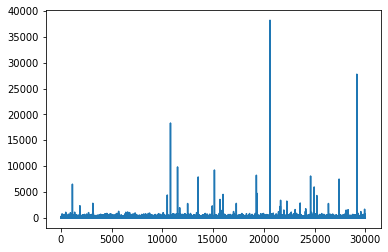

In [144]:
sim_sum_tot[sim_sum_tot['Loss']==0]['HardAccelerations'].plot()

In [145]:
sim_sum_tot[sim_sum_tot['Loss']==1].describe()

,Vehicle,Days,Distance,HardBrakes,HardAccelerations,NightTime_Pct,Loss
count,4031.000000,4031.0,4031.000000,4031.000000,4031.000000,4031.000000,4031.0
mean,15052.420491,365.0,14757.022823,170.241131,138.251054,0.031782,1.0
std,8614.665175,0.0,4514.713625,495.044167,534.856132,0.054822,0.0
min,4.000000,365.0,2488.000000,0.000000,0.000000,0.000000,1.0
25%,7653.500000,365.0,11550.500000,41.000000,25.000000,0.001000,1.0
50%,15071.000000,365.0,14369.000000,98.000000,68.000000,0.008000,1.0
75%,22361.000000,365.0,17477.500000,208.000000,159.000000,0.038000,1.0
max,29981.000000,365.0,34805.000000,16315.000000,24629.000000,0.761000,1.0


In [146]:
sim_sum_tot[sim_sum_tot['Loss']==0].describe()

,Vehicle,Days,Distance,HardBrakes,HardAccelerations,NightTime_Pct,Loss
count,25969.000000,25969.0,25969.000000,25969.000000,25969.000000,25969.000000,25969.0
mean,14992.440718,365.0,13440.090762,167.442951,104.528130,0.029429,0.0
std,8667.612853,0.0,4204.589699,569.999916,376.432155,0.054906,0.0
min,1.000000,365.0,2911.000000,0.000000,0.000000,0.000000,0.0
25%,7477.000000,365.0,10405.000000,39.000000,20.000000,0.001000,0.0
50%,14992.000000,365.0,13039.000000,98.000000,56.000000,0.007000,0.0
75%,22530.000000,365.0,16028.000000,205.000000,129.000000,0.033000,0.0
max,30000.000000,365.0,35159.000000,35639.000000,38221.000000,0.888000,0.0


# Model
This model will be employing a densely connected feed forward neural network for event classification
Activation functions: 
    rectified linear unit (ReLU) activation function such that the gradients of activation functions will not diminish as you increase the depth of the network
    sigmoid activation function is applied to the output layer as is standard for classification problems
    
Loss/Response Function:
    Binary Cross Entropy will be used to calculate the predicted probability (probability of correct classification based on the input values)  Larger predicted probabilites correspond to lower response function values for correctly identified events.

Optimization Function:
    Adam (Adaptive moment estimation) Optimizer which is the standard efficient optimization function that calulates adaptive learning rates for all parameters in the network.  It computes exponentially weighted averages of past gradients and squares of gradients
    
I'll split up the input dataset into 2 dataframes, X:the useful input values (dropping Loss as it is the classifier, Vehicle which is effectively an index, and Days which is 365 for every row, and y: the truth value of loss prediction

First I'll show an extremely naive approach just taking in the disparate raw datasets before moving onto using the same approach with oversampled minority case events using both the SMOTE and ADASYN oversampling techniques.

In [147]:
sim_sum_tot = sim_sum_tot.replace("Car", 0)
sim_sum_tot = sim_sum_tot.replace("SUV", 1)
sim_sum_tot = sim_sum_tot.replace("Truck", 2)
sim_sum_tot = sim_sum_tot.replace("Minivan", 3)

X = sim_sum_tot.drop(['Loss','Vehicle', 'Days'], axis=1)
y = sim_sum_tot['Loss']

In [148]:
#splitting up the signal and background datasets into training sets, testing sets, and validation sets. 
#This splits into 64% to be used for training and 16% testing and 16% validation
ix = range(y.shape[0]) 
X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(X, y, ix, train_size=0.8)
X_train, X_val,y_train, y_val,ix_train, ix_val=train_test_split(X_train,y_train,ix_train,test_size=0.2)

In [149]:
#Neural networks prefer inputs that are similar to each other while at the same time as normally distributed as possible
#sklearn has a variety of scalers that can be used to perform this transformation, here I use RobustScalar
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [3]:
DNNmodel(Input_shape=(15,),n_hidden=5,n_nodesHidden=128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_______________________________

In [2]:
#A Function for making various depths and complexities of dense neural networks
def DNNmodel(Input_shape=(10,), n_hidden=1, n_nodesHidden=20, dropout=0.2, optimizer='adam'):
        inputs=Input(shape=Input_shape)
        i=0
        if n_hidden>0:
                hidden=Dense(n_nodesHidden, activation='relu')(inputs)
                hidden=Dropout(dropout)(hidden)
                i+=1
        while i<n_hidden:
                hidden=Dense(n_nodesHidden, activation='relu')(hidden)
                hidden=Dropout(dropout)(hidden)
                i+=1
        outputs = Dense(1,activation='sigmoid')(hidden)
        model = Model(inputs,outputs)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return model

In [151]:
model = DNNmodel(Input_shape=(5,),n_hidden=2)

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
dense_56 (Dense)             (None, 20)                120       
_________________________________________________________________
dropout_42 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_43 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 21        
Total params: 561
Trainable params: 561
Non-trainable params: 0
____________________________________________________________

In [152]:
model.fit(X_train,y_train,epochs=50,callbacks=[EarlyStopping(verbose=True,patience=10,monitor='val_loss')], validation_data=(X_val, y_val),batch_size=10)

Train on 19200 samples, validate on 4800 samples
Epoch 1/50
19200/19200 [==============================] - 2s 122us/step - loss: 0.4184 - accuracy: 0.8645 - val_loss: 0.4054 - val_accuracy: 0.8610
Epoch 2/50
19200/19200 [==============================] - 2s 105us/step - loss: 0.3952 - accuracy: 0.8670 - val_loss: 0.4040 - val_accuracy: 0.8606
Epoch 3/50
19200/19200 [==============================] - 2s 107us/step - loss: 0.3906 - accuracy: 0.8672 - val_loss: 0.4031 - val_accuracy: 0.8610
Epoch 4/50
19200/19200 [==============================] - 2s 106us/step - loss: 0.3893 - accuracy: 0.8672 - val_loss: 0.4022 - val_accuracy: 0.8610
Epoch 5/50
19200/19200 [==============================] - 2s 106us/step - loss: 0.3897 - accuracy: 0.8672 - val_loss: 0.4022 - val_accuracy: 0.8610
Epoch 6/50
19200/19200 [==============================] - 2s 105us/step - loss: 0.3884 - accuracy: 0.8672 - val_loss: 0.4014 - val_accuracy: 0.8610
Epoch 7/50
19200/19200 [==============================] - 2s 10

In [153]:
history = model.history.history
print("history keys: ", history.keys())

history keys:  dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


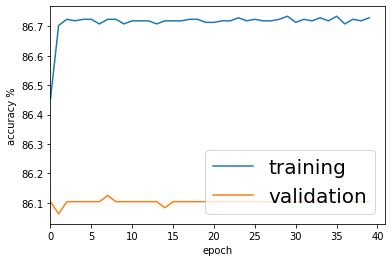

In [154]:
#Accuracy plot
plt.plot(100 * np.array(history['accuracy']), label='training')
plt.plot(100 * np.array(history['val_accuracy']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.legend(loc='lower right', fontsize=20)


In [155]:
yhat = model.predict(X_test, verbose = True, batch_size = 512) 

6000/6000 [==============================] - 0s 52us/step


In [156]:
yhat_cls = np.argmax(yhat, axis=1)

Text(0, 0.5, 'Events')

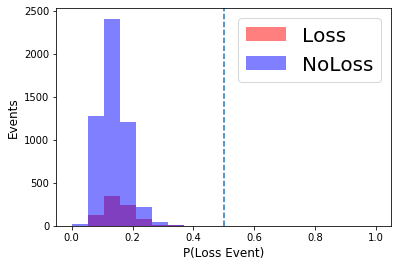

In [157]:
bins = np.linspace(0, 1, 20)
_ = plt.hist(yhat[y_test==1], histtype='stepfilled', alpha=0.5, color='red', label=r"Loss", bins=bins)
_ = plt.hist(yhat[y_test==0], histtype='stepfilled', alpha=0.5, color='blue', label=r'NoLoss', bins=bins)
plt.axvline(x=0.5, linestyle='--')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('P(Loss Event)', fontsize='large')
plt.ylabel('Events', fontsize='large')

In [158]:
LossAcc = yhat[y_test==1].round().sum()/y_test.sum()
print("Loss Event Accuracy: %.1f%%" %(LossAcc*100))

Loss Event Accuracy: 0.0%


It is obvious from this that the neural network, at least with the sample given is not sufficient without taking into consideration the disparate nature of the signal/background like events. Even though there is clearly a shape difference in the distributions all events are classified as 'No Loss' because of the large pull from the significant number of 'No Loss' events compared to 'Loss' Events.  The network accuracy goes to the percentage of events in the majority case while classifying all signal events incorrectly. To account for this I will preform oversampling

# Resampling, NN part 2
Let's try to do some resampling using Adaptive Synthetic Sampling, focuses on data that are hard to learn, fills in more edge cases than the next technique (SMOTE) which fills more linearlly between events.
https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.ADASYN.html

In [87]:
#Upscale the minority class such that each class has roughly equal representation
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy="auto")
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
np.bincount(y_train_adasyn)

array([16643, 17066], dtype=int64)

In [88]:
model = DNNmodel(Input_shape=(5,),n_hidden=3);
model.fit(X_train_adasyn,y_train_adasyn,epochs=100,callbacks=[EarlyStopping(verbose=True,patience=20,monitor='val_loss')], validation_data=(X_val, y_val),batch_size=10)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
dense_44 (Dense)             (None, 20)                120       
_________________________________________________________________
dropout_33 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_34 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_35 (Dropout)         (None, 20)                0  

history keys:  dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


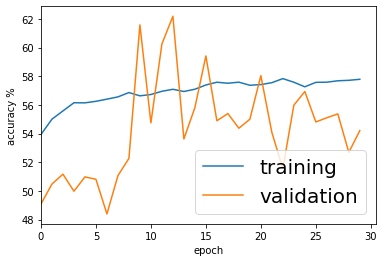

In [89]:
history = model.history.history
print("history keys: ", history.keys())
#Accuracy plot
plt.plot(100 * np.array(history['accuracy']), label='training')
plt.plot(100 * np.array(history['val_accuracy']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.legend(loc='lower right', fontsize=20)

6000/6000 [==============================] - 0s 44us/step


Text(0, 0.5, 'Events')

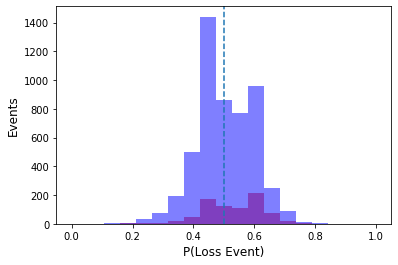

In [90]:
yhat = model.predict(X_test, verbose = True, batch_size = 512) 
yhat_cls = np.argmax(yhat, axis=1)
sum(yhat_cls)
bins = np.linspace(0, 1, 20)
_ = plt.hist(yhat[y_test==1], histtype='stepfilled', alpha=0.5, color='red', label=r"Signal", bins=bins)
_ = plt.hist(yhat[y_test==0], histtype='stepfilled', alpha=0.5, color='blue', label=r'Background', bins=bins)
plt.axvline(x=0.5,linestyle='--')
plt.xlabel('P(Loss Event)', fontsize='large')
plt.ylabel('Events', fontsize='large')

In [91]:
print("Loss Events: mean: %.3f, std: %.3f" %(yhat[y_test==1].mean(),yhat[y_test==1].std()))
print("NoLoss Events: mean: %.3f, std: %.3f" %(yhat[y_test==0].mean(),yhat[y_test==0].std()))

Loss Events: mean: 0.535, std: 0.094
NoLoss Events: mean: 0.503, std: 0.092


In [92]:
LossAcc = yhat[y_test==1].round().sum()/y_test.sum()
print("Loss Event Accuracy: %.1f%%" %(LossAcc*100))

Loss Event Accuracy: 61.2%


# Resampling using SMOTE
Synthetic minority oversampling technique (Smote) generates synthetic data that is similar to, but not exactly like the minority class using nearest-neightbors approach to fill in space between neighbors.

In [99]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy="auto")
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
np.bincount(y_train_smote)

array([16643, 16643], dtype=int64)

In [100]:
model = DNNmodel(Input_shape=(5,),n_hidden=3);
model.fit(X_train_smote,y_train_smote,epochs=100,callbacks=[EarlyStopping(verbose=True,patience=20,monitor='val_loss')], validation_data=(X_val, y_val),batch_size=10)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
dense_52 (Dense)             (None, 20)                120       
_________________________________________________________________
dropout_39 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_40 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_41 (Dropout)         (None, 20)                0  

history keys:  dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


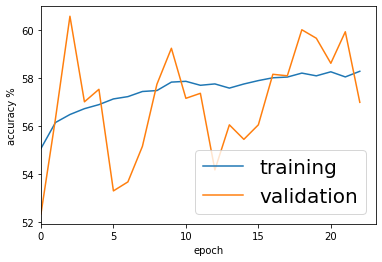

In [101]:
history = model.history.history
print("history keys: ", history.keys())
#Accuracy plot
plt.plot(100 * np.array(history['accuracy']), label='training')
plt.plot(100 * np.array(history['val_accuracy']), label='validation')
plt.xlim(0)
plt.xlabel('epoch')
plt.ylabel('accuracy %')
plt.legend(loc='lower right', fontsize=20)

6000/6000 [==============================] - 0s 50us/step


Text(0, 0.5, 'Events')

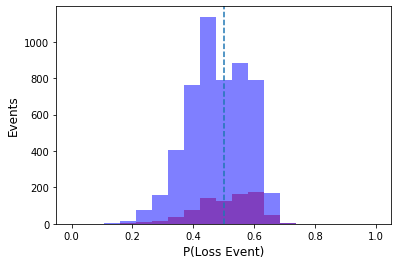

In [102]:
yhat = model.predict(X_test, verbose = True, batch_size = 512) 
bins = np.linspace(0, 1, 20)
_ = plt.hist(yhat[y_test==1], histtype='stepfilled', alpha=0.5, color='red', label=r"Signal", bins=bins)
_ = plt.hist(yhat[y_test==0], histtype='stepfilled', alpha=0.5, color='blue', label=r'Background', bins=bins)
plt.axvline(x=0.5,linestyle='--')
plt.xlabel('P(Loss Event)', fontsize='large')
plt.ylabel('Events', fontsize='large')

In [103]:
print("Loss Events: mean: %.3f, std: %.3f" %(yhat[y_test==1].mean(),yhat[y_test==1].std()))
print("NoLoss Events: mean: %.3f, std: %.3f" %(yhat[y_test==0].mean(),yhat[y_test==0].std()))

Loss Events: mean: 0.510, std: 0.096
NoLoss Events: mean: 0.480, std: 0.097


In [104]:
LossAcc = yhat[y_test==1].round().sum()/y_test.sum()
print("Loss Event Accuracy: %.1f%%" %(LossAcc*100))

Loss Event Accuracy: 55.7%


# Let's try a BDT instead of a NN, with ADASYN Resampling

Change to XGBoost friendlier format, using all potentially useful columns, dropping Vehicle (an index) and Days (always 365, no chance of separation between loss type events)

In [105]:
#splitting up the signal and background datasets into training sets, testing sets, and validation sets. 
#This splits into 80% to be used for training and 20% testing
X = sim_sum_tot.drop(['Vehicle', 'Days'], axis=1)
y = sim_sum_tot['Loss']
ix = range(y.shape[0]) 
#X=X.drop('Loss',axis=1)
X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(X, y, ix, train_size=0.8)
#X_train, X_val,y_train, y_val,ix_train, ix_val=train_test_split(X_train,y_train,ix_train,test_size=0.2)

In [106]:
X.columns

Index(['Distance', 'HardBrakes', 'HardAccelerations', 'NightTime_Pct',
       'VehicleType', 'Loss'],
      dtype='object')

In [107]:
adasyn = ADASYN(sampling_strategy="auto")
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
np.bincount(y_train_adasyn)

array([20744, 20434], dtype=int64)

In [108]:
X_train_adasyn

,Distance,HardBrakes,HardAccelerations,NightTime_Pct,VehicleType,Loss
0,14762,541,12,0.191000,3,0
1,13565,113,54,0.000000,0,0
2,25507,132,119,0.005000,0,0
3,21419,454,78,0.000000,1,0
4,8054,57,129,0.057000,0,0
...,...,...,...,...,...,...
41173,11563,72,73,0.042493,1,1
41174,11577,97,64,0.090249,1,1
41175,11558,48,106,0.078863,0,1
41176,11559,49,106,0.075842,0,1


In [109]:
print('Number of training samples: {}'.format(len(X_train)))
print('Number of testing samples: {}'.format(len(X_test)))
print('ADASYN: Number of training samples: {}'.format(len(X_train_adasyn)))

print('\nNumber of signal events in training set: {}'.format(len(X_train[X_train.Loss == 1])))
print('ADASYN:Number of signal events in training set: {}'.format(len(X_train_adasyn[X_train_adasyn.Loss == 1])))
print('Number of background events in training set: {}'.format(len(X_train[X_train.Loss == 0])))
print('Fraction signal: {}'.format(len(X_train[X_train.Loss == 1])/(float)(len(X_train[X_train.Loss == 1]) + len(X_train[X_train.Loss == 0]))))
print('ADASYN: Fraction signal: {}'.format(len(X_train_adasyn[X_train_adasyn.Loss == 1])/(float)(len(X_train_adasyn[X_train_adasyn.Loss == 1]) + len(X_train_adasyn[X_train_adasyn.Loss == 0]))))

Number of training samples: 24000
Number of testing samples: 6000
ADASYN: Number of training samples: 41178

Number of signal events in training set: 3256
ADASYN:Number of signal events in training set: 20434
Number of background events in training set: 20744
Fraction signal: 0.13566666666666666
ADASYN: Fraction signal: 0.49623585409684784


In [110]:
features = X_train.columns[:-1]  # we skip the last column because it is the Loss label
features

Index(['Distance', 'HardBrakes', 'HardAccelerations', 'NightTime_Pct',
       'VehicleType'],
      dtype='object')

In [111]:
binary_bdt_param = {
    "learning_rate" : 0.15,
    "max_depth" : 6,
    "colsample_bytree" : 1.0,
    "subsample" : 1.0,
    "n_estimators" : 200,
    "feature_names" : features,
    'objective' : 'binary:logistic' # objective function
}
binary_task_param = {
    "eval_metric" : ["logloss","error"],
    "early_stopping_rounds" : 30,
    "eval_set": [(X_train_adasyn[features],y_train_adasyn), 
                 (X_test[features],y_test)]
}

binary_bdt = xgb.XGBClassifier(**binary_bdt_param)
binary_bdt.fit(X_train_adasyn[features], y_train_adasyn,
              verbose=False, **binary_task_param)

[20:07:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=Index(['Distance', 'HardBrakes', 'HardAccelerations', 'NightTime_Pct',
       'VehicleType'],
      dtype='object'),
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [112]:
evaluated_df = X_test.copy()
evaluated_df["binary_prob"] = binary_bdt.predict_proba(X_test[features])[:,1]
print(binary_bdt.score(X_test[features],y_test))

binary_bdt.predict_proba(X_test[features])[:,1].round().sum()

0.808


547.0

In [113]:
y_pred = binary_bdt.predict(X_test[features])
y_pred.sum()

547

In [114]:
binary_bdt.predict(X_test[features])

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

In [115]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

predictions = binary_bdt.predict(X_test[features])
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
thresholds = np.sort(binary_bdt.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(binary_bdt, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_adasyn[features])
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train_adasyn)
    # eval model
    select_X_test = selection.transform(X_test[features])
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Loss Event Accuracy: %.2f%%"%(predictions[y_test==1].sum()/y_test.sum()*100.))
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 80.80%
Loss Event Accuracy: 10.32%
Thresh=0.056, n=5, Accuracy: 80.98%
Loss Event Accuracy: 10.32%
Thresh=0.057, n=4, Accuracy: 81.93%
Loss Event Accuracy: 9.16%
Thresh=0.078, n=3, Accuracy: 82.18%
Loss Event Accuracy: 4.77%
Thresh=0.292, n=2, Accuracy: 83.87%
Loss Event Accuracy: 2.97%
Thresh=0.515, n=1, Accuracy: 83.83%


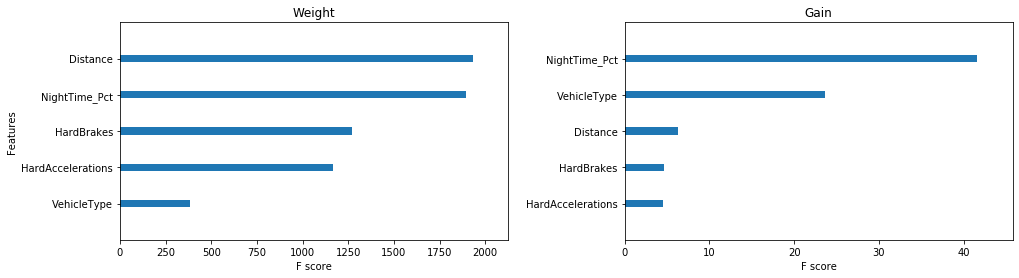

In [116]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,4))
xgb.plot_importance(binary_bdt, importance_type="weight", ax=ax_enum[0], title="Weight",show_values=False, grid=False)
xgb.plot_importance(binary_bdt, importance_type="gain", ax=ax_enum[1], title="Gain", show_values=False, grid=False)
plt.ylabel("")
plt.sca(ax_enum[1])
plt.ylabel("")
plt.subplots_adjust(wspace=0.3)

importance_type=Gain is how useful is the variable in terms of separation where importance_type=Weight is how frequently splitting on the variable occurs

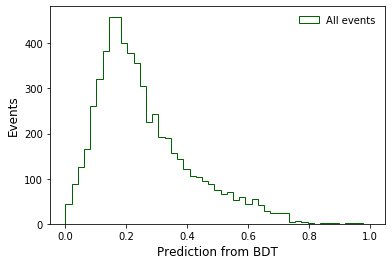

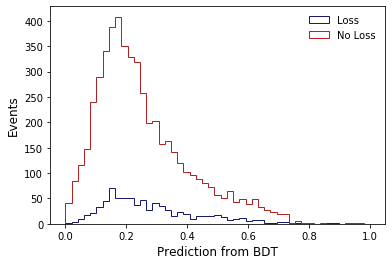

In [117]:
# plot all predictions (both signal and background)
predictions = binary_bdt.predict_proba(X_test[features])[:,1]
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(binary_bdt.predict_proba(X_test[features][y_test==1])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Loss');
plt.hist(binary_bdt.predict_proba(X_test[features][y_test==0])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='No Loss');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

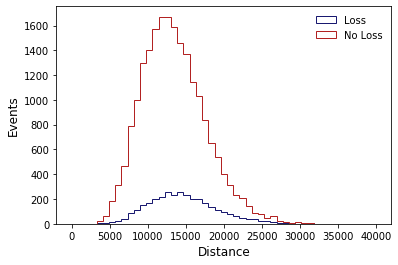

In [118]:

plt.figure();
plt.hist(X_train.Distance[X_train.Loss == 1],bins=np.linspace(0,40000,50),
         histtype='step',color='midnightblue',label='Loss');
plt.hist(X_train.Distance[X_train.Loss == 0],bins=np.linspace(0,40000,50),
         histtype='step',color='firebrick',label='No Loss');

plt.xlabel('Distance',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

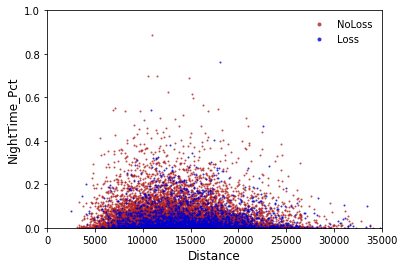

In [119]:
plt.figure();
#plt.plot(X_train_adasyn.Distance[X_train_adasyn.Loss == 0],X_train_adasyn.NightTime_Pct[X_train_adasyn.Loss == 0],
#         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.8,label='NoLoss');
#plt.plot(X_train_adasyn.Distance[X_train_adasyn.Loss == 1],X_train_adasyn.NightTime_Pct[X_train_adasyn.Loss == 1],
#         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.8,label='Loss');

plt.plot(X_train.Distance[X_train.Loss == 0],X_train.NightTime_Pct[X_train.Loss == 0],
         'o',markersize=2,color='firebrick',markeredgewidth=0,alpha=0.8,label='NoLoss');
plt.plot(X_train.Distance[X_train.Loss == 1],X_train.NightTime_Pct[X_train.Loss == 1],
         'o',markersize=2,color='mediumblue',markeredgewidth=0,alpha=0.8,label='Loss');

plt.xlim(0,35000);
plt.ylim(0.0,1);
#plt.yscale('log')
plt.xlabel('Distance',fontsize=12);
plt.ylabel('NightTime_Pct',fontsize=12);
plt.legend(frameon=False,numpoints=1,markerscale=2);

# BDT with SMOTE resampling

Change to XGBoost friendlier format, using all potentially useful columns, dropping Vehicle (an index) and Days (always 365, no chance of separation between loss type events)

In [120]:
#splitting up the signal and background datasets into training sets, testing sets, and validation sets. 
#This splits into 80% to be used for training and 20% testing
X = sim_sum_tot.drop(['Vehicle', 'Days'], axis=1)
y = sim_sum_tot['Loss']
ix = range(y.shape[0]) 
#X=X.drop('Loss',axis=1)
X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(X, y, ix, train_size=0.8)
#X_train, X_val,y_train, y_val,ix_train, ix_val=train_test_split(X_train,y_train,ix_train,test_size=0.2)

In [121]:
X.columns

Index(['Distance', 'HardBrakes', 'HardAccelerations', 'NightTime_Pct',
       'VehicleType', 'Loss'],
      dtype='object')

In [122]:
adasyn = SMOTE(sampling_strategy="auto")
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
np.bincount(y_train_smote)

array([20796, 20796], dtype=int64)

In [123]:
X_train_smote

,Distance,HardBrakes,HardAccelerations,NightTime_Pct,VehicleType,Loss
0,15595,446,16,0.017000,1,1
1,17220,207,155,0.009000,2,0
2,14428,167,2,0.003000,2,0
3,7961,103,1,0.056000,3,0
4,13196,1,10,0.024000,1,0
...,...,...,...,...,...,...
41587,11544,63,142,0.159022,2,1
41588,19066,288,188,0.022176,2,1
41589,14291,77,38,0.078869,2,1
41590,15489,77,386,0.013539,0,1


In [124]:
print('Number of training samples: {}'.format(len(X_train)))
print('Number of testing samples: {}'.format(len(X_test)))
print('SMOTE: Number of training samples: {}'.format(len(X_train_smote)))

print('\nNumber of signal events in training set: {}'.format(len(X_train[X_train.Loss == 1])))
print('SMOTE:Number of signal events in training set: {}'.format(len(X_train_smote[X_train_smote.Loss == 1])))
print('Number of background events in training set: {}'.format(len(X_train[X_train.Loss == 0])))
print('Fraction signal: {}'.format(len(X_train[X_train.Loss == 1])/(float)(len(X_train[X_train.Loss == 1]) + len(X_train[X_train.Loss == 0]))))
print('SMOTE: Fraction signal: {}'.format(len(X_train_smote[X_train_smote.Loss == 1])/(float)(len(X_train_adasyn[X_train_smote.Loss == 1]) + len(X_train_smote[X_train_smote.Loss == 0]))))

Number of training samples: 24000
Number of testing samples: 6000
SMOTE: Number of training samples: 41592

Number of signal events in training set: 3204
SMOTE:Number of signal events in training set: 20796
Number of background events in training set: 20796
Fraction signal: 0.1335
SMOTE: Fraction signal: 0.5050269561416291


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [125]:
features = X_train.columns[:-1]  # we skip the last column because it is the Loss label
features

Index(['Distance', 'HardBrakes', 'HardAccelerations', 'NightTime_Pct',
       'VehicleType'],
      dtype='object')

In [126]:
binary_bdt_param = {
    "learning_rate" : 0.15,
    "max_depth" :6,
    "colsample_bytree" : 1.0,
    "subsample" : 1.0,
    "n_estimators" : 200,
    "feature_names" : features,
    'objective' : 'binary:logistic' # objective function
}
binary_task_param = {
    "eval_metric" : ["logloss","error"],
    "early_stopping_rounds" : 30,
    "eval_set": [(X_train_adasyn[features],y_train_adasyn), 
                 (X_test[features],y_test)]
}

binary_bdt = xgb.XGBClassifier(**binary_bdt_param)
binary_bdt.fit(X_train_smote[features], y_train_smote,
              verbose=False, **binary_task_param)

[20:07:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { feature_names } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=Index(['Distance', 'HardBrakes', 'HardAccelerations', 'NightTime_Pct',
       'VehicleType'],
      dtype='object'),
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [127]:
evaluated_df = X_test.copy()
evaluated_df["binary_prob"] = binary_bdt.predict_proba(X_test[features])[:,1]
print(binary_bdt.score(X_test[features],y_test))

binary_bdt.predict_proba(X_test[features])[:,1].round().sum()

0.8045


520.0

In [128]:
y_pred = binary_bdt.predict(X_test[features])
y_pred.sum()

520

In [129]:
binary_bdt.predict(X_test[features])

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [130]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

predictions = binary_bdt.predict(X_test[features])
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
thresholds = np.sort(binary_bdt.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(binary_bdt, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_smote[features])
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train_smote)
    # eval model
    select_X_test = selection.transform(X_test[features])
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Loss Event Accuracy: %.2f%%"%(predictions[y_test==1].sum()/y_test.sum()*100.))
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 80.45%
Loss Event Accuracy: 12.58%
Thresh=0.060, n=5, Accuracy: 80.30%
Loss Event Accuracy: 10.28%
Thresh=0.062, n=4, Accuracy: 81.22%
Loss Event Accuracy: 10.88%
Thresh=0.084, n=3, Accuracy: 80.97%
Loss Event Accuracy: 4.35%
Thresh=0.273, n=2, Accuracy: 83.18%
Loss Event Accuracy: 3.87%
Thresh=0.521, n=1, Accuracy: 83.95%


In [131]:
predictions[y_test==1].sum()/y_test.sum()
y_pred[y_test==1].sum()/y_test.sum()

0.10519951632406288

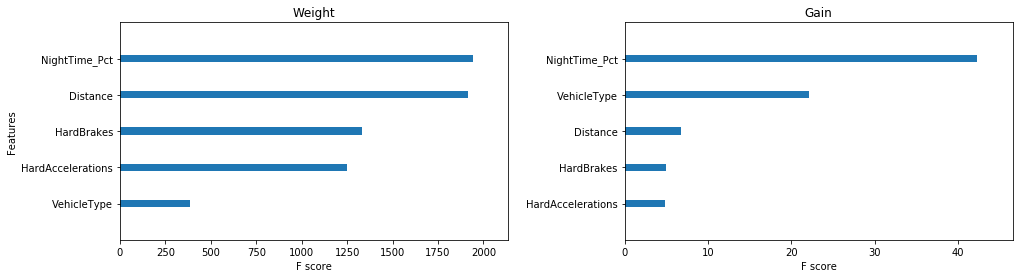

In [132]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,4))
xgb.plot_importance(binary_bdt, importance_type="weight", ax=ax_enum[0], title="Weight",show_values=False, grid=False)
xgb.plot_importance(binary_bdt, importance_type="gain", ax=ax_enum[1], title="Gain", show_values=False, grid=False)
plt.ylabel("")
plt.sca(ax_enum[1])
plt.ylabel("")
plt.subplots_adjust(wspace=0.3)

importance_type=Gain is how useful is the variable in terms of separation where importance_type=Weight is how frequently splitting on the variable occurs

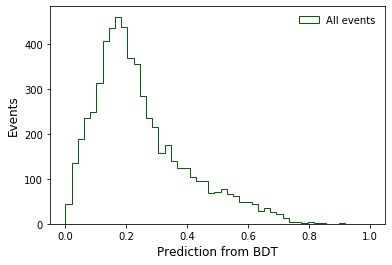

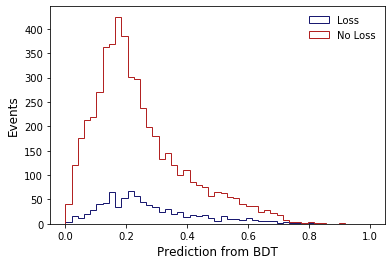

In [133]:
# plot all predictions (both signal and background)
predictions = binary_bdt.predict_proba(X_test[features])[:,1]
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(binary_bdt.predict_proba(X_test[features][y_test==1])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Loss');
plt.hist(binary_bdt.predict_proba(X_test[features][y_test==0])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='No Loss');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

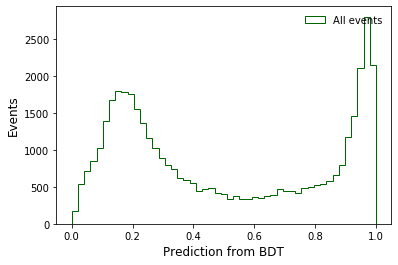

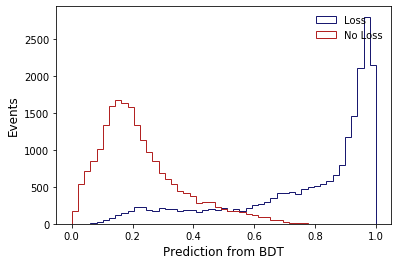

In [134]:
#Looking at the training set to make sure things still behave, we see they look good
# However the smote events are the ones making up the clearly defined tail 
# plot all predictions (both signal and background)
predictions = binary_bdt.predict_proba(X_train_smote[features])[:,1]
plt.figure();
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);

# plot signal and background separately
plt.figure();
plt.hist(binary_bdt.predict_proba(X_train_smote[features][y_train_smote==1])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Loss');
plt.hist(binary_bdt.predict_proba(X_train_smote[features][y_train_smote==0])[:,1],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='No Loss');
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12);
plt.ylabel('Events',fontsize=12);
plt.legend(frameon=False);